# Unsupervised Detection of Financial Market Regimes from Macro-Financial Snapshots

## Feature set for regime detection 

### 1. 10Y - 2Y treasury spread

Classic proxy for the broader economic cycle

Source (FRED) :
1. DGS10 : 10Y yield
2. DGS2 : 2Y yield

Compute : DGS10 - DGS2

### 2. Credit spreads

Captures risk appetite in debt markets

Source (FRED) :
1. BAMLC0A0CM : High investment grade
2. BAMLH0A0HYM2 : Low investment grade

### 3. Real 10Y interest rates

Captures monetory policy stance after inflation

Source (FRED):
1. DFII10 : TIPS 10Y 

### 4. Volatility of S&P

Source (yfinance):
1. ^GSPC : Ticker for the S&P 500 index on yfinance. 


In [1786]:
from infrastructure import get_data, process_data, clustering
import importlib
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



importlib.reload(get_data)
importlib.reload(process_data)
importlib.reload(clustering)

<module 'infrastructure.clustering' from '/Users/aryanchatterjee/Dev/regime_modeling/research/infrastructure/clustering.py'>

In [1787]:
tickers = ["^RUT", "^GSPC"]

start = "1999-01-01"
end = "2025-09-25"

indices_data = get_data.get_data_yfinance(tickers,start,end)

/Users/aryanchatterjee/Dev/regime_modeling/research/infrastructure/get_data.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  for ticker in tickers :
[*********************100%***********************]  2 of 2 completed


## Data Pre-processing

In [1788]:
def run_pre_processing_pipeline():
    feature_names = ['^GSPC','BAMLC0A0CM','DFII10','DGS10','DGS2']
    macro_features = ['BAMLC0A0CM','DFII10','DGS10', 'DGS2']

    data_frames_raw_dict = get_data.collect_raw_data(feature_names)
    data_frames_raw_dict = process_data.align_start_dates(data_frames_raw_dict)
    aligned_df = process_data.merge_data(data_frames_raw_dict)

    # --- Daily returns ---
    daily_ret = aligned_df['^GSPC'].pct_change()

    # --- Monthly realized volatility (annualized) ---
    monthly_vol = (
        daily_ret.resample('M').std() * np.sqrt(252)   # ~21 trading days per month
    )

    monthly_df = process_data.resample_data(aligned_df,feature_names,'M',True)
    monthly_df['^GSPC_vol'] = monthly_vol

    monthly_df = monthly_df.dropna()

    return monthly_df

In [1789]:
monthly_df = run_pre_processing_pipeline()
monthly_df.to_csv('monthly_df.csv')

/var/folders/47/jjw2l5d95jv3bt4m9ny26_2m0000gn/T/ipykernel_40189/3589233362.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_ret.resample('M').std() * np.sqrt(252)   # ~21 trading days per month
/Users/aryanchatterjee/Dev/regime_modeling/research/infrastructure/process_data.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[col] = df[col].resample(sampling).mean() if mean else df[col].resample(sampling).last()


In [1790]:
print(len(monthly_df)) 

272


In [1791]:
monthly_df.head()

,^GSPC,BAMLC0A0CM,DFII10,DGS10,DGS2,^GSPC_vol
Date,,,,,,
2003-01-31,897.100673,1.769333,2.297931,4.048966,1.741034,0.188481
2003-02-28,838.805361,1.696786,2.009259,3.917407,1.634444,0.154427
2003-03-31,848.524194,1.647419,1.946774,3.810645,1.571935,0.226954
2003-04-30,888.773332,1.473333,2.185185,3.958148,1.615185,0.157493
2003-05-31,936.582252,1.317742,1.911333,3.572667,1.419667,0.134238


In [1792]:
def get_features_df(df, cols):
    features_df = df[cols].copy()
    features_df = process_data.normalize_data(features_df)
    return features_df

In [1793]:
features_df_macro = get_features_df(monthly_df, ['BAMLC0A0CM', 'DFII10', 'DGS10', 'DGS2'])
features_df_mkt = get_features_df(monthly_df, ['^GSPC_vol'])


## Regime Clustering

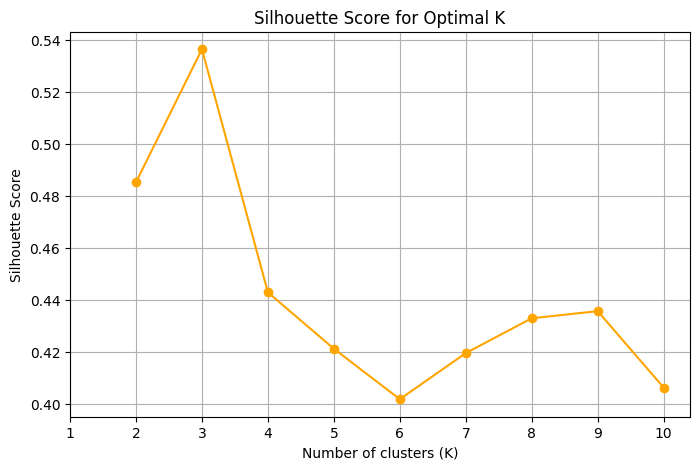

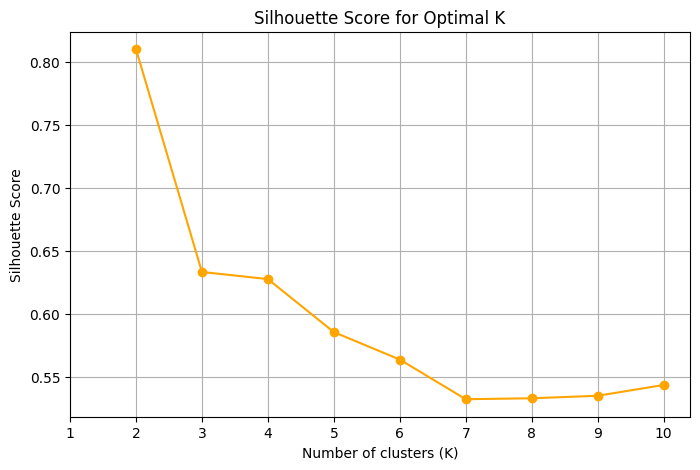

In [1794]:
k_macro, score_macro = clustering.get_sil_scores(features_df_macro,plot=True)
k_mkt, score_mkt = clustering.get_sil_scores(features_df_mkt,plot=True)

In [1795]:
print(f"Macro sil results : {k_macro} {score_macro}")
print(f"Mkt sil results : {k_mkt} {score_mkt}")

Macro sil results : 3 0.5363037332778444
Mkt sil results : 2 0.8104306014317326


In [1796]:
features_df_macro = clustering.get_regimes(features_df_macro,'macro',k_macro)
features_df_mkt = clustering.get_regimes(features_df_mkt,'mkt',k_mkt)
monthly_df['macro'] = features_df_macro['macro']
monthly_df['mkt'] = features_df_mkt['mkt']
monthly_df['regime'] = monthly_df['macro'].astype(str)+monthly_df['mkt'].astype(str)


In [1797]:
monthly_df.head()

,^GSPC,BAMLC0A0CM,DFII10,DGS10,DGS2,^GSPC_vol,macro,mkt,regime
Date,,,,,,,,,
2003-01-31,897.100673,1.769333,2.297931,4.048966,1.741034,0.188481,1,0,10
2003-02-28,838.805361,1.696786,2.009259,3.917407,1.634444,0.154427,1,0,10
2003-03-31,848.524194,1.647419,1.946774,3.810645,1.571935,0.226954,1,0,10
2003-04-30,888.773332,1.473333,2.185185,3.958148,1.615185,0.157493,1,0,10
2003-05-31,936.582252,1.317742,1.911333,3.572667,1.419667,0.134238,1,0,10


In [1798]:
regime_summary = monthly_df.groupby('regime').mean()
regime_summary['DGS10-DGS2'] = regime_summary['DGS10'] - regime_summary['DGS2']
regime_summary

,^GSPC,BAMLC0A0CM,DFII10,DGS10,DGS2,^GSPC_vol,macro,mkt,DGS10-DGS2
regime,,,,,,,,,
00,2333.741732,1.458605,0.225065,2.245788,0.919304,0.113982,0.0,0.0,1.326484
01,2199.090087,2.395619,-0.147965,1.270860,0.299912,0.509758,0.0,1.0,0.970948
10,2543.448863,1.139648,1.925117,4.248725,3.661396,0.111565,1.0,0.0,0.587329
11,5351.093685,1.108889,2.039259,4.274815,3.781111,0.409925,1.0,1.0,0.493704
20,1094.216789,3.396858,1.606471,3.578167,1.541550,0.190408,2.0,0.0,2.036617
21,912.369545,5.546800,2.152743,3.097089,1.211106,0.448629,2.0,1.0,1.885983


In [1799]:
# yield curve slope , credit spread , S&P vol
regime_labels = {
    '00' : 'Steep-Tight-Calm',
    '01' : 'Flat-SlightWide-Volatile',
    '10' : 'Flat-Tight-Calm',
    '11' : 'Flat-Tight-Volatile',
    '20' : 'Steep-Wide-SlightVolatile',
    '21' : 'Steep-Wide-Volatile'
}

In [1800]:
monthly_df['regime_label'] = monthly_df['regime'].map(regime_labels)

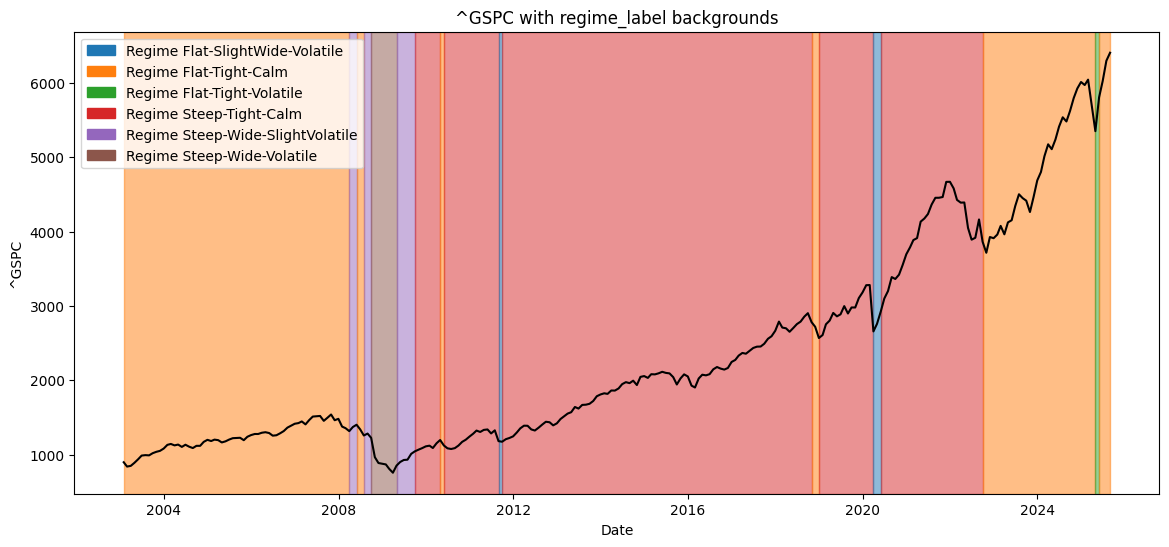

In [1801]:

def plot_regimes_with_background(df, price_col="^GSPC", regime_col="Regime", figsize=(14,6)):
    plt.figure(figsize=figsize)

    # Plot the S&P 500 line
    plt.plot(df.index, df[price_col], color="black", linewidth=1.5, label=price_col)

    # Get unique regimes and assign colors
    regimes = df[regime_col].unique()
    colors = plt.cm.tab10.colors  # up to 10 regimes
    color_map = {regime: colors[i % len(colors)] for i, regime in enumerate(sorted(regimes))}

    # Add background shading for each contiguous regime
    prev_regime = None
    start_date = None
    for date, regime in zip(df.index, df[regime_col]):
        if regime != prev_regime:
            if prev_regime is not None:
                plt.axvspan(start_date, date, color=color_map[prev_regime], alpha=0.5)
            start_date = date
            prev_regime = regime
    # Close off last regime
    plt.axvspan(start_date, df.index[-1], color=color_map[prev_regime], alpha=0.5)

    # Legend
    patches = [mpatches.Patch(color=color_map[r], label=f"Regime {r}") for r in sorted(regimes)]
    plt.legend(handles=patches, loc="best")

    plt.title(f"{price_col} with {regime_col} backgrounds")
    plt.xlabel("Date")
    plt.ylabel(price_col)
    plt.show()

# Usage
plot_regimes_with_background(monthly_df, price_col="^GSPC", regime_col="regime_label")


## Narration of timelines

### 1. 2003 - 2008 :

Regime : Flat 10-2 , Tight Credit Spread , Calm markets (Unshaken optimism)

Bull run before the 2008 crash. Yield curve is more or less flat giving macro warnings but investors in general do not mind.
Credit spreads remain tight keeping financing easy for corporates and equity market does not show high volatility. 

### 2. 2008 - 2010/11 :

Regimes :

a. Steep 10-2 , Wide Credit Spread , Slightly Volatile markets (Transition in/out of crisis)

b. Steep 10-2 , Wide Credit Spread , Volatile markets (Meltdown)

Leading into the crisis, the Fed has stepped in here and made sure the 10-2 spread is steep again. However, credit spreads have widened making financing difficult for corporates. 

However, equity markets get pessimistic late and optimistic quickly. There is a period of extreme volatility. But volatility comes back down from extreme levels although credit spreads remain high. 

### 3. 2010/11 - 2022 :

a. Steep 10-2 , Tight Credit Spread , Calm markets (Slow calm Growth)

b. Flat 10-2 , Slightly Wide Credit Spread , Volatile market (Covid)

Predominantly normal conditions except for the Covid pandemic towards the end. During the pandemic, credit spreads do widen but not as much as before and equity market is extremely volatile. However, it does not last as long as the 2008 crash and markets recover quickly and go back to the bull phase of (a)

### 4. 2022 - Present :

a. Flat 10-2 , Tight Credit Spread , Calm markets (Unshaken optimism)

b. Flat 10-2 , Tight Credit Spread , Volatile markets (Tariff trouble)

Predominantly like the 2003 to 2008 bull run. Market and corporate bond investors do not respond to flattening yield curve and continue to remain optimistic. However, there is a short period of volatile markets. 


## Major volatility events

1. 2008 Financial Crisis : Major problem with corporate credit + Market Volatility due to complete loss of faith in the financial system
2. 2011 Euro Crisis : Moderate corporate credit issues + Market Volatiltiy due to European exposure 
3. 2020 Covid Pandemic : Moderate corporate credit issue + Market Volatility as a reaction to major potential earnings losses and GDP tanking
4. 2025 Tariffs : No issues with corporate credit + Market Volatility mainly due to Tariff exposure and cost considerations

## Qualitative Analysis 

There are a few points which pop out after looking at the regimes.

### 1. Duration of volatility events

Volatility events do not last for too long in general. In fact, calm conventional growth and unshaken optimism tends to last much longer than high volatility periods. 

### 2. Effect of Credit Spreads on volatility in equity markets

Credit spreads have a clear effect on volatility in the stock market. In fact, widening credit spreads correspond almost perfectly to market volatility. There is one exception : the recent tarriff trouble. Markets moved violently once tarriffs were anounced but credit spreads did not widen. In fact, the magnitute of the credit spread and how long it lasts seems to be directly proportional to how long a volatility event lasts.

The longest volatility event is the 2008 meltdown and the period is characterized by wide credit spreads both before markets become volatile and even after markets begin to recover. 

Unless accompanied by wide credit spreads then, there appears to be mean reversion dynamics at play for equities. The market reacts violently to news but recovers. However, this recovery is much slower if there is a broader problem in the corporate bonds world. 

### 3. Sustained Unshaken optimism

There are sustained periods of flat yield curves but tight credit spreads and low volatility. Both, investors in corporate bonds and in stock markets can go a long time without getting concerned about the 10-2 spread. Conventional wisdom would say this is shaky ground, but the length to which such periods can last is surprising. 

Big shorts during such periods without fundamental bottom up research would not do well. For instance, just because it seems like dangerous territory, is not enough to have a short bias. Need credit signals or some other news events for the regime to switch

